# Spotify Song analysis

Group 40

In [48]:
# Import helpers from the Standard Library
from itertools import product
from operator import itemgetter

# Standard imports for plotting etc.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# All sklearn-related imports
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# Import NN libraries
import torch
from torch import nn
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Data Pipeline


The dataset is split into a train and test set with 80% training data and 20% testing data, using argument 'random_state = 109'. The test data is stored in a test.csv file for later use.

In [2]:
# Data Pipeline
data_set = pd.read_csv("/data/notebook_files/spotify_all_decades.csv").rename(columns={"Unnamed: 0": "orig_idx"})
data_set["decade"] = data_set["decade"].replace({60: 1960, 70: 1970, 80: 1980, 90: 1990, 0: 2000, 10: 2010})
X = data_set.drop(['target'], axis=1)
y = data_set['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=109)

# Save test and train data
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
X_train_copy["target"] = y_train
X_test_copy["target"] = y_test
X_train_copy.to_csv("/data/notebook_files/train.csv")
X_test_copy.to_csv("/data/notebook_files/test.csv")

In [3]:
#shape of original data set 
print('Original data set includes ' f'{data_set.shape[0]}' ' observations and '  f'{data_set.shape[1]}' ' features')

Original data set includes 41106 observations and 21 features


## 2. Exploratory Data Analysis

In this part, we just explore the data to get to know it a little better to help us inform modeling choices later.

In [4]:
# First 3 throws of the data
display(X_train.head(3))

orig_idx 
 track 
 artist 
 uri 
 danceability 
 energy 
 key 
 loudness 
 mode 
 speechiness 
 acousticness 
 instrumentalness 
 liveness 
 valence 
 tempo 
 duration_ms 
 time_signature 
 chorus_hit 
 sections 
 decade 
 
 
 
 
 31649 
 3323 
 Potpourri nach Motiven aus der Oper Euryanthe ... 
 Joseph Küffner 
 spotify:track:1055Z97gPIwZQa7WzLzTVC 
 0.321 
 0.0372 
 0 
 -25.095 
 1 
 0.0384 
 0.99000 
 0.859000 
 0.1110 
 0.324 
 110.932 
 190360 
 4 
 67.06529 
 7 
 2000 
 
 
 34129 
 5803 
 Zoom 
 Lil' Boosie Featuring Yung Joc 
 spotify:track:1Uq394qwP4Nz9ZonRr3RrA 
 0.779 
 0.6160 
 11 
 -8.852 
 0 
 0.1500 
 0.00265 
 0.000083 
 0.3390 
 0.171 
 160.919 
 285040 
 4 
 27.25900 
 12 
 2000 
 
 
 2031 
 2031 
 California Soul 
 Gerald Wilson Orchestra 
 spotify:track:4SwzHlEIydxwesGMcMo4A7 
 0.431 
 0.5450 
 2 
 -9.605 
 1 
 0.0265 
 0.35400 
 0.030100 
 0.0815 
 0.669 
 106.002 
 250733 
 4 
 35.80236 
 13 
 1960

### 2.1 Features in the data

Below we explore what features we are dealing with, looking at their type and the range of values they take.

In [5]:
# Features of the data
X_train.columns.to_numpy().reshape(-1, 1)

array([['orig_idx'],
 ['track'],
 ['artist'],
 ['uri'],
 ['danceability'],
 ['energy'],
 ['key'],
 ['loudness'],
 ['mode'],
 ['speechiness'],
 ['acousticness'],
 ['instrumentalness'],
 ['liveness'],
 ['valence'],
 ['tempo'],
 ['duration_ms'],
 ['time_signature'],
 ['chorus_hit'],
 ['sections'],
 ['decade']], dtype=object)

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32884 entries, 31649 to 19701
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   orig_idx          32884 non-null  int64  
 1   track             32884 non-null  object 
 2   artist            32884 non-null  object 
 3   uri               32884 non-null  object 
 4   danceability      32884 non-null  float64
 5   energy            32884 non-null  float64
 6   key               32884 non-null  int64  
 7   loudness          32884 non-null  float64
 8   mode              32884 non-null  int64  
 9   speechiness       32884 non-null  float64
 10  acousticness      32884 non-null  float64
 11  instrumentalness  32884 non-null  float64
 12  liveness          32884 non-null  float64
 13  valence           32884 non-null  float64
 14  tempo             32884 non-null  float64
 15  duration_ms       32884 non-null  int64  
 16  time_signature    32884 non-null  in

In [7]:
X_train.describe()

orig_idx 
 danceability 
 energy 
 key 
 loudness 
 mode 
 speechiness 
 acousticness 
 instrumentalness 
 liveness 
 valence 
 tempo 
 duration_ms 
 time_signature 
 chorus_hit 
 sections 
 decade 
 
 
 
 
 count 
 32884.000000 
 32884.000000 
 32884.000000 
 32884.000000 
 32884.000000 
 32884.000000 
 32884.000000 
 32884.000000 
 32884.000000 
 32884.000000 
 32884.000000 
 32884.000000 
 3.288400e+04 
 32884.000000 
 32884.000000 
 32884.000000 
 32884.000000 
 
 
 mean 
 3510.866592 
 0.540625 
 0.579612 
 5.220046 
 -10.215710 
 0.694259 
 0.073019 
 0.364138 
 0.153525 
 0.201319 
 0.543170 
 119.287031 
 2.353076e+05 
 3.893596 
 40.051972 
 10.497050 
 1982.773081 
 
 
 std 
 2130.555925 
 0.177732 
 0.252480 
 3.536017 
 5.287118 
 0.460728 
 0.085396 
 0.339006 
 0.302779 
 0.172955 
 0.267248 
 29.067141 
 1.213890e+05 
 0.421883 
 18.763569 
 4.950347 
 17.529000 
 
 
 min 
 0.000000 
 0.057600 
 0.000251 
 0.000000 
 -49.253000 
 0.000000 
 0.022000 
 0.000000 
 0.000000 
 0.013000 
 0.000000 
 31.988000 
 1.516800e+04 
 0.000000 
 0.000000 
 0.000000 
 1960.000000 
 
 
 25% 
 1700.000000 
 0.421000 
 0.396000 
 2.000000 
 -12.813000 
 0.000000 
 0.033700 
 0.039200 
 0.000000 
 0.094000 
 0.331000 
 97.434500 
 1.728898e+05 
 4.000000 
 27.603608 
 8.000000 
 1970.000000 
 
 
 50% 
 3422.000000 
 0.553000 
 0.601000 
 5.000000 
 -9.260000 
 1.000000 
 0.043500 
 0.258000 
 0.000115 
 0.132000 
 0.559000 
 117.402000 
 2.179200e+05 
 4.000000 
 35.867565 
 10.000000 
 1980.000000 
 
 
 75% 
 5146.000000 
 0.670000 
 0.787000 
 8.000000 
 -6.372000 
 1.000000 
 0.070325 
 0.677000 
 0.058800 
 0.261000 
 0.768000 
 136.375500 
 2.670032e+05 
 4.000000 
 47.632388 
 12.000000 
 2000.000000 
 
 
 max 
 8641.000000 
 0.988000 
 1.000000 
 11.000000 
 2.291000 
 1.000000 
 0.957000 
 0.996000 
 1.000000 
 0.997000 
 0.996000 
 241.423000 
 4.170227e+06 
 5.000000 
 262.615400 
 169.000000 
 2010.000000

We will drop the features "orig_idx","track","artist" and "uri", and use the remaining variables to build the models

In [8]:
predictors = X_train.columns.drop(["orig_idx", "track", "artist", "uri"])
predictors

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'chorus_hit', 'sections', 'decade'],
      dtype='object')

In [9]:
# Drop features "orig_idx","track","artist" and "uri", 
X_train = X_train[predictors]
X_train.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'chorus_hit', 'sections', 'decade'],
      dtype='object')

Lastly we seperate the features into to categories i.e numerical and categorical

In [10]:
numerical_pred = ['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature','chorus_hit','sections']
categorical_pred = ['key', 'decade', 'mode']

### 2.2 Distribution of Response Variable

Response variable is evenly distributed between ‘Hit’ and ‘Flop’ in all decades. This is useful as we do not have to account for class imbalances in our models.

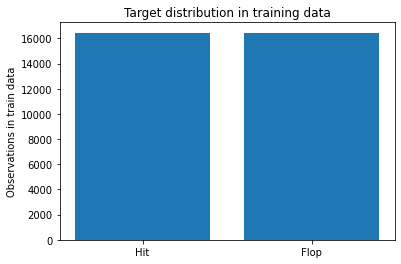

In [11]:
# Distribution of response variable
plt.bar(["Hit", "Flop"], [(y_train == 1).sum(), (y_train == 0).sum()])
plt.ylabel("Observations in train data")
plt.title("Target distribution in training data");

In [12]:
# Distribution of the response variable divided between the six decades
target_mean=X_train.copy()
target_mean["Target mean training data"]=y_train
np.round(target_mean.groupby("decade").mean()["Target mean training data"], 2)

decade
1960 0.50
1970 0.50
1980 0.50
1990 0.50
2000 0.51
2010 0.50
Name: Target mean training data, dtype: float64

### 2.3 Missing Entries

We observe that there are is no missing entries in the data set, which is very nice for the subsequent modeling as we do not have to consider what to do about the missingness.

In [13]:
# Count of null/na entries for each feature
X_train.isna().sum()

danceability 0
energy 0
key 0
loudness 0
mode 0
speechiness 0
acousticness 0
instrumentalness 0
liveness 0
valence 0
tempo 0
duration_ms 0
time_signature 0
chorus_hit 0
sections 0
decade 0
dtype: int64

### 2.4 Explore association between predictors

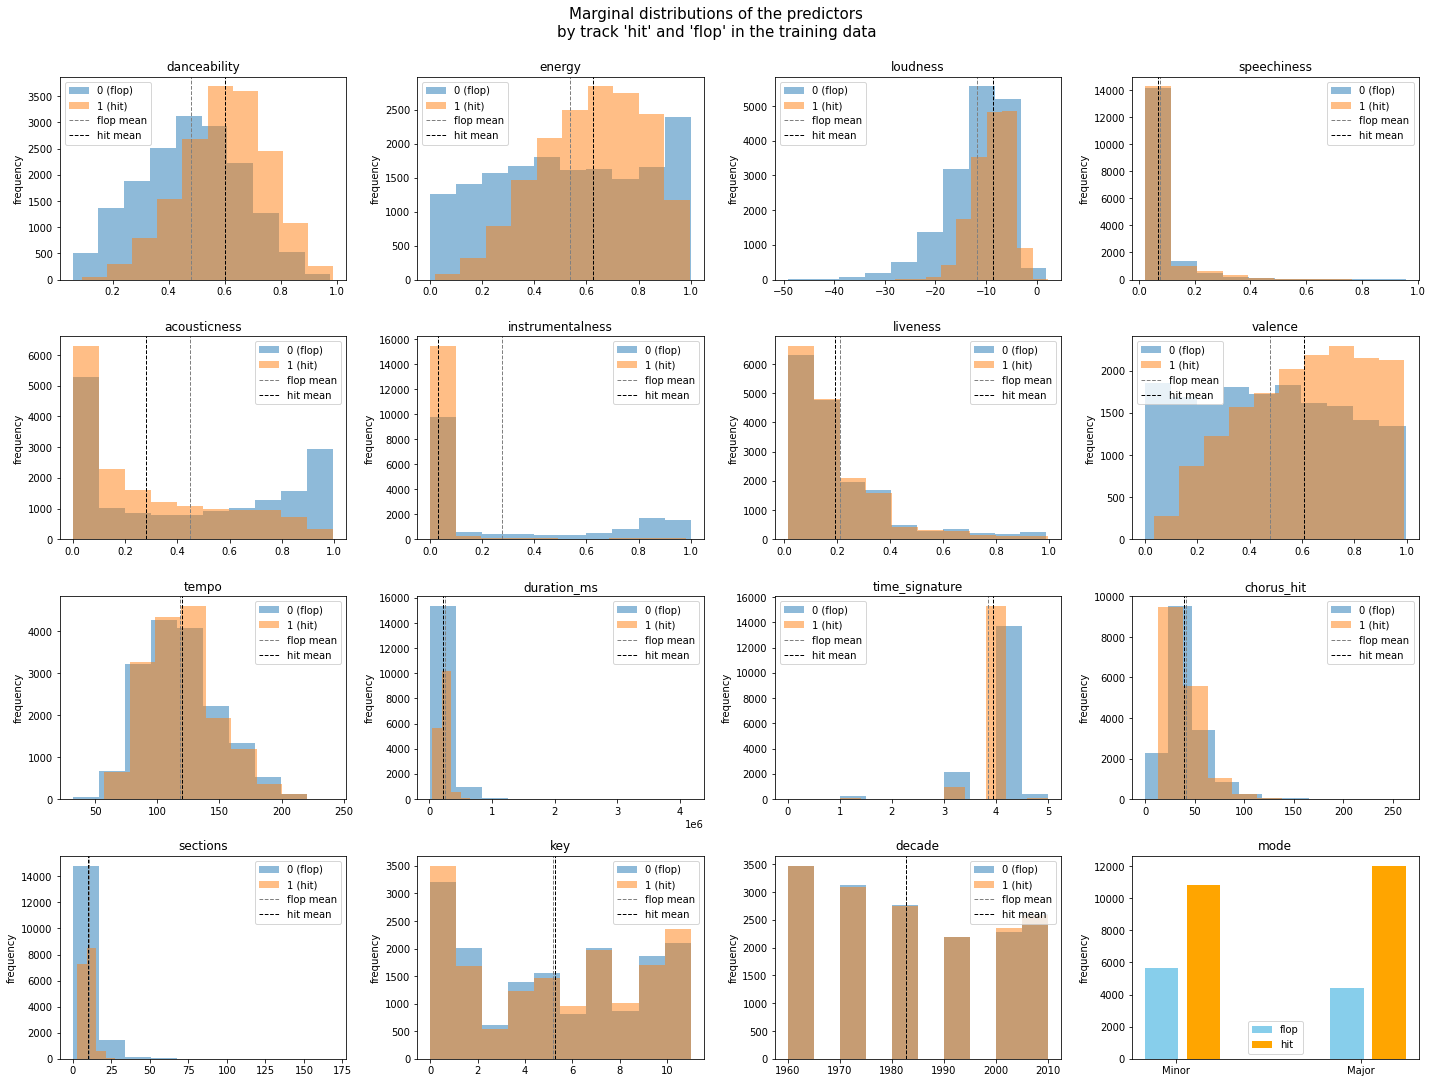

In [14]:
# Plotting each predictor against the repsonse variable
X_train_full = X_train.copy()
X_train_full['target'] = y_train

fig, axes = plt.subplots(4, 4, figsize=(20,15))

for pred, ax in zip(numerical_pred + categorical_pred[0:2], axes.ravel()[:-1]):
    pred_flop = X_train_full.query("target == 0")[f"{pred}"]
    pred_hit = X_train_full.query("target == 1")[f"{pred}"]

    ax.hist(pred_flop, alpha=0.5, label='0 (flop)')
    ax.hist(pred_hit, alpha=0.5, label='1 (hit)')
    ax.axvline(pred_flop.mean(), color='grey', linestyle='dashed', linewidth=1, label = 'flop mean')
    ax.axvline(pred_hit.mean(), color='k', linestyle='dashed', linewidth=1, label = 'hit mean')

    ax.legend()

    ax.set_ylabel("frequency")
    ax.set_title(f"{pred}")


# Plot mode 
ax = axes.ravel()[-1]
mode_0_flop = len(X_train_full.query("mode == 0 and target == 0"))
mode_1_flop = len(X_train_full.query("mode == 1 and target == 0"))
mode_0_hit = len(X_train_full.query("mode == 0 and target == 1"))
mode_1_hit = len(X_train_full.query("mode == 1 and target == 1"))

ax.bar(0-0.15/2, height=mode_0_flop, color='skyblue', label='flop', width=0.18)
ax.bar(0+0.15, height=mode_1_flop, color='orange', label='hit', width=0.18)
ax.bar(1-0.15/2, height=mode_0_hit, color='skyblue', width=0.18)
ax.bar(1+0.15, height=mode_1_hit, color='orange', width=0.18)
ax.set_xticks([0,1], ["Minor", "Major"])
ax.set_ylabel("frequency")
ax.set_title("mode")
ax.legend()

plt.suptitle(
    "Marginal distributions of the predictors\n"
    "by track 'hit' and 'flop' in the training data",
    fontsize=15, y=1,
)
plt.tight_layout()
plt.savefig('marg_distri')
plt.show()

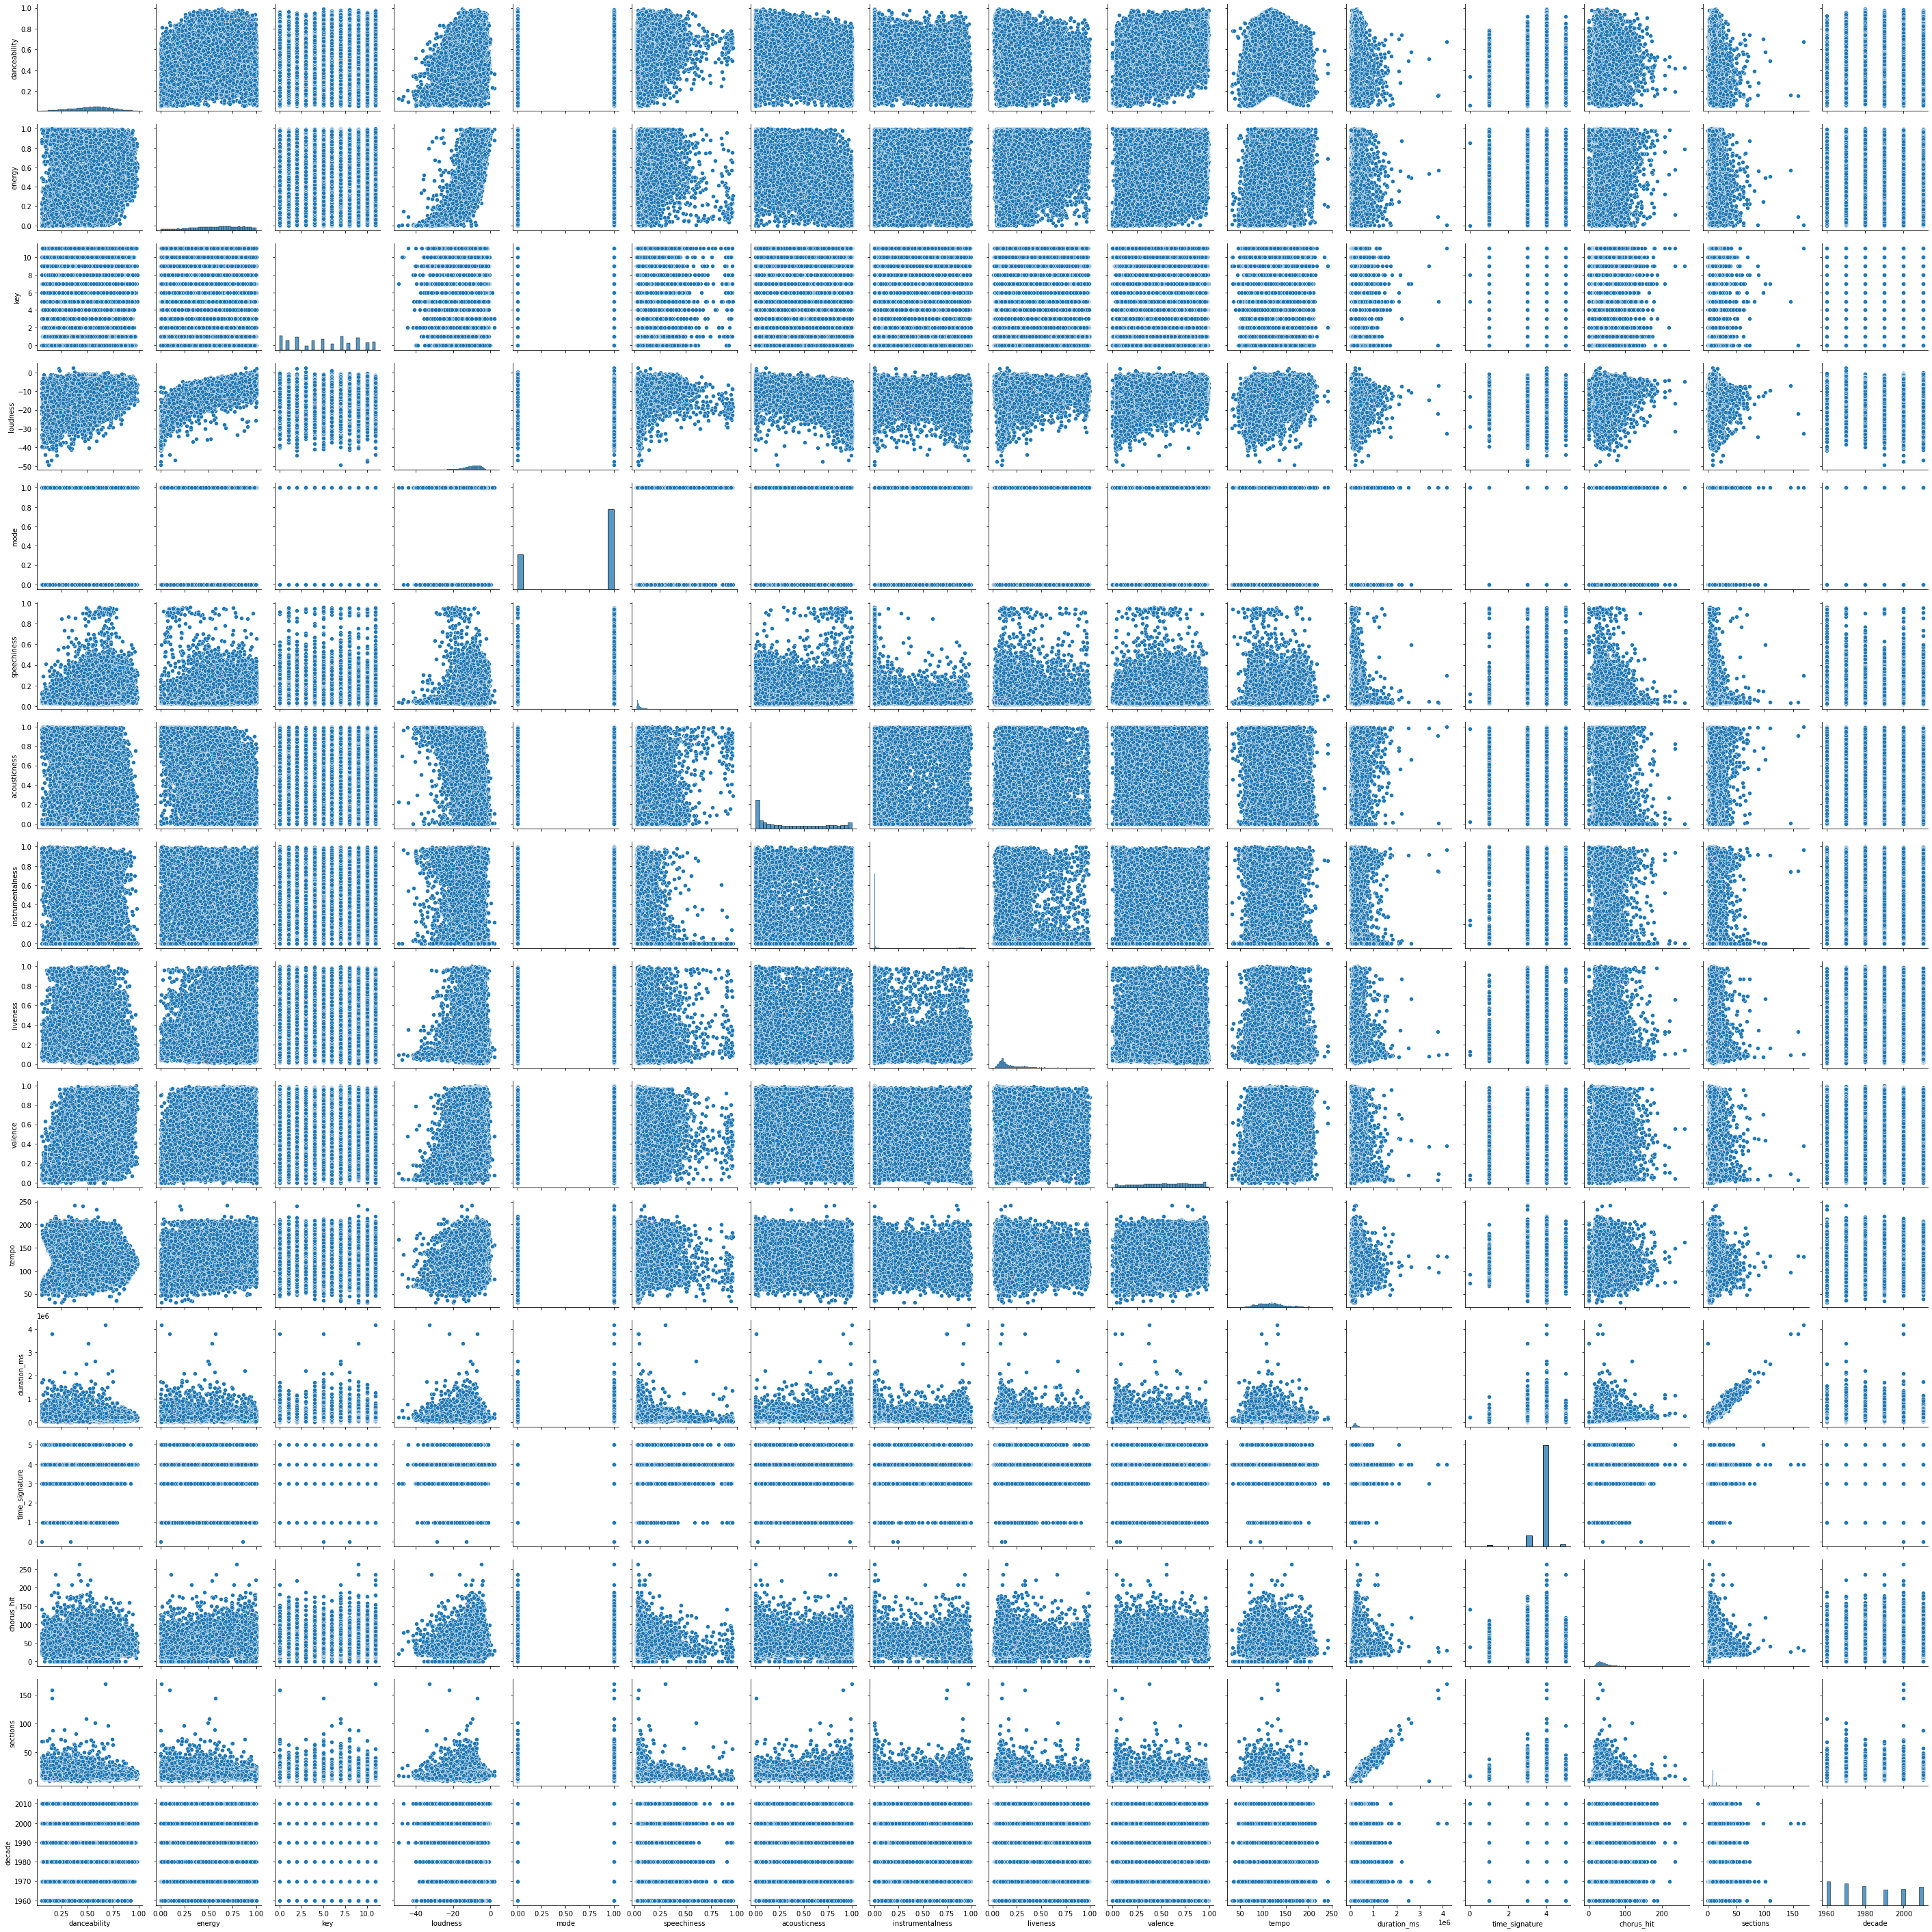

In [15]:
# Pairwise plot of every predictor
sns.pairplot(X_train);

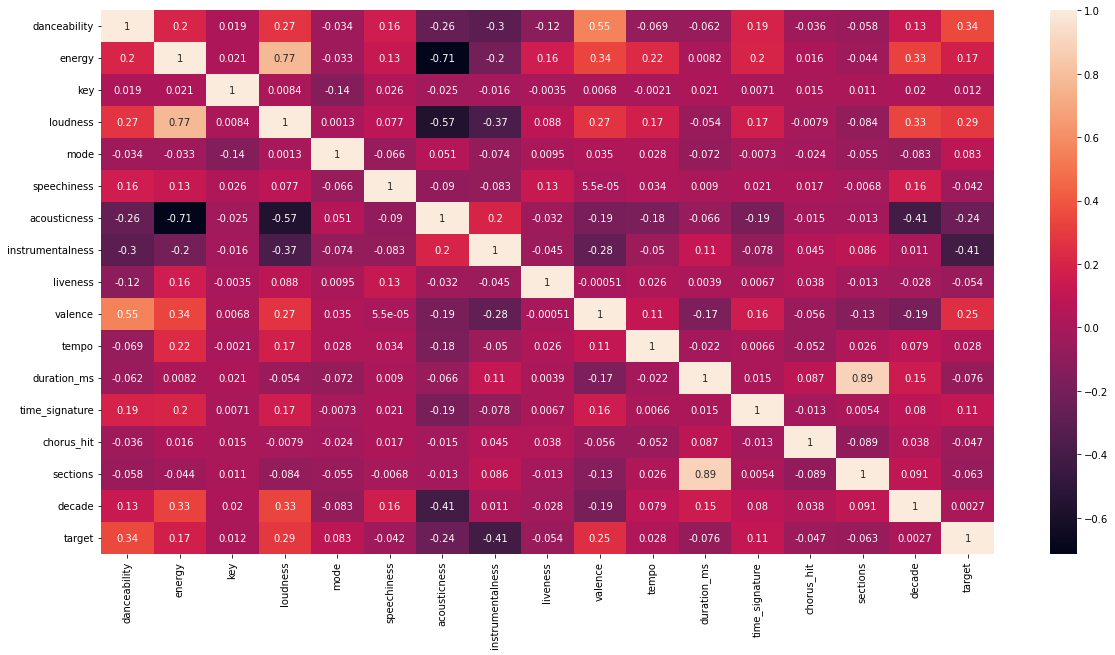

In [16]:
# Correlation table between each feature and response variable
plt.figure(figsize=(20, 10))
sns.heatmap(X_train_full.corr(), annot=True)
plt.savefig('correlation_table')

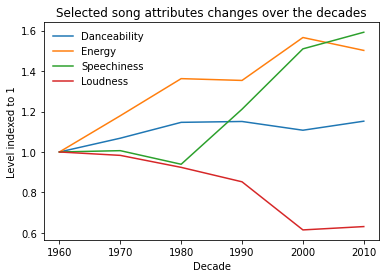

In [17]:
decades = X_train.groupby("decade").mean()
plt.plot(decades.danceability/decades.danceability.iloc[0], label="Danceability")
plt.plot(decades.energy/decades.energy.iloc[0], label="Energy")
plt.plot(decades.speechiness/decades.speechiness.iloc[0], label="Speechiness")
plt.plot(decades.loudness/decades.loudness.iloc[0], label="Loudness")

plt.legend(frameon=False)
plt.xlabel("Decade")
plt.ylabel("Level indexed to 1")
plt.title("Selected song attributes changes over the decades")
plt.savefig('change_over_decades')

## 3. Modeling


### 3.1 Scale Data

We plan to train a logistic regression model with regularisation, hence as required we scale the data. For consistency, the scaled train data set is used to build/train all models.

In [18]:
# Scale data 
scaler = StandardScaler()
X_train = X_train[predictors]
X_train_scaled = scaler.fit_transform(X_train)

### 3.1 Naive models

In [19]:
# Models are based the following predictors
predictors = X_train.columns
predictors

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'chorus_hit', 'sections', 'decade'],
      dtype='object')

In [20]:
# Logistic regression
logistic = LogisticRegression(max_iter=10000)
cros_val_logistic = cross_val_score(logistic, X_train_scaled, y_train, cv=10)

In [21]:
# Tree
tree = DecisionTreeClassifier(max_depth=10)
cros_val = cross_val_score(tree, X_train_scaled, y_train, cv=10)

In [22]:
# Bagging tree
tree = DecisionTreeClassifier(max_depth=10)
bagger = BaggingClassifier(tree, n_estimators=50)
cros_val_bagger = cross_val_score(bagger, X_train_scaled, y_train, cv=10)

In [23]:
# AdaBoost
tree = DecisionTreeClassifier(max_depth=10)
ada_boost = AdaBoostClassifier(tree)
cros_val_adaboost = cross_val_score(ada_boost, X_train_scaled, y_train)

In [24]:
# Evaluate the trhee base models
scores = [np.mean(y_train), np.mean(cros_val_logistic), np.mean(cros_val), np.mean(cros_val_bagger)]
stds = [0, np.std(cros_val_logistic), np.std(cros_val), np.std(cros_val_bagger)]
names = ["Naive predictor","Logistic regression","Single tree","Bagging tree",]
scores_df_base = pd.DataFrame(list(zip(names, scores, stds)),
                              columns=["Model", "Cross val mean", "Cross val std"])

In [29]:
np.round(scores_df_base,4,)

Model 
 Cross val mean 
 Cross val std 
 
 
 
 
 0 
 Naive predictor 
 0.4997 
 0.0000 
 
 
 1 
 Logistic regression 
 0.7398 
 0.0050 
 
 
 2 
 Single tree 
 0.7603 
 0.0059 
 
 
 3 
 Bagging tree 
 0.7930 
 0.0079

### 3.2 Train and Tune Models


#### 3.2.1 Single DecisionTree

Below, we search for the optimal tree depth within a parameter space of 1-21.

In [31]:
# 5-fold Cross Validation
tree_depths = list(range(1,21))
cvmeans = []
cvstds = []
for tree_depth in tree_depths:
    dt = DecisionTreeClassifier(max_depth = tree_depth)
    val_scores = cross_val_score(dt, X_train_scaled, y_train, cv=5)
    cvmeans.append(np.mean(val_scores))
    cvstds.append(np.std(val_scores))

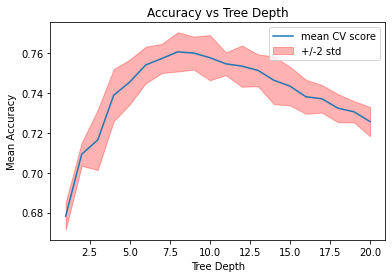

In [32]:
# Plot results from CV above
plt.plot(tree_depths,cvmeans,label ='mean CV score')
plt.fill_between(tree_depths, y1= np.array(cvmeans)+2*np.array(cvstds), y2=np.array(cvmeans)-2*np.array(cvstds),color = 'red',alpha=0.3,label='+/-2 std')
plt.title('Accuracy vs Tree Depth')
plt.ylabel('Mean Accuracy')
plt.xlabel('Tree Depth')
plt.legend()
plt.show()

In [33]:
best_cv_depth = tree_depths[np.argmax(cvmeans)]
dt_best_cv_depth = DecisionTreeClassifier(max_depth = best_cv_depth).fit(X_train[predictors],y_train)
print(f'Tree depth {best_cv_depth} achieves highest CV mean score')

Tree depth 8 achieves highest CV mean score


In [34]:
cv_results_tree = cross_validate(dt_best_cv_depth, X_train_scaled, y_train,
                                 cv=5, scoring='accuracy', return_train_score=True)

In [35]:
train_accuracy_tree= cv_results_tree['train_score'].mean()
val_accuracy_tree = cv_results_tree['test_score'].mean()

In [36]:

print(
    "The best tree of max-depth {} "
    ", achieves the following accuracy scores:"
    "\n\n\ttrain\t{:.4f}\n\tval\t{:.4f}".format(
        best_cv_depth,
        train_accuracy_tree,
        val_accuracy_tree,
    )
)

The best tree of max-depth 8 , achieves the following accuracy scores:

	train	0.7902
	val	0.7607


#### 3.2.2 Logistic Regression

In [165]:
# Logistic model with polynomrial features and optimal ridge penalizer
logistic_pipe = Pipeline([
    ("PolyFeat",PolynomialFeatures(degree=2)),
    ("LogisticRegression",LogisticRegression(verbose=1,penalty="l2",C=21.54,n_jobs=-1,max_iter=1000))
])
logistic_pipe.fit(X_train_scaled,y_train)
train_accuracy_logistic = logistic_pipe.score(X_train_scaled,y_train)
print('train accuracy of logistic regression: ', train_accuracy_logistic)

train accuracy of logistic regression:  0.7915095487167011


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s finished


#### 3.2.3 Random Forests

With help of GridSearchCV, we found the optimal hyperparameters for a Random Forest Model. We let max depth ranged of 6-19, number of estimator from 100-500. We held the number of predictors We keept the number of features to consider when looking for the best split constant with max_features = "sqrt".

In [34]:
rf = GridSearchCV(RandomForestClassifier(max_features="sqrt"),
                  {"max_depth": list(range(6, 20, 1)), "n_estimators": list(range(100, 501, 100))},
                  scoring="accuracy")
rf.fit(X_train_scaled, y_train)

GridSearchCV(estimator=RandomForestClassifier(max_features='sqrt'),
             param_grid={'max_depth': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                       17, 18, 19],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='accuracy')

From the GridSearchCV we obtained that a Random Forest model with max depth of 19, 500 estimators and max features being the square root generated the best validation accuracy. Below, we report the train and validaton accuracy of the Random Forest model trained with the optimal hyperparamters.

In [37]:
# Fit a model with the optimal hyperparamters
best_rf = RandomForestClassifier(max_depth=19, n_estimators=500, max_features="sqrt")
cv_results_rf = cross_validate(best_rf, X_train_scaled, y_train, cv=5, scoring='accuracy',
                               return_train_score=True)

In [38]:
train_accuracy_rf = cv_results_rf['train_score'].mean()
val_accuracy_rf = cv_results_rf['test_score'].mean()

In [39]:
print(
    "The best random forest (of max-depth 19 and n_estimators 500) \n"
    ", achieves the following accuracy scores:"
    "\n\n\ttrain\t{:.4f}\n\tval\t{:.4f}".format(
        train_accuracy_rf,
        val_accuracy_rf,
    )
)

The best random forest (of max-depth 19 and n_estimators 500) 
, achieves the following accuracy scores:

	train	0.9696
	val	0.8034


#### 3.2.4 AdaBoost

With the help of GridSearchCV we find the optimal set of three hyper-parameters i.e tree depth, number of estimators and learning rate. However, before GridSearchCV is performed, we determine feasible parameter spaces for each hyper-parameter
by tuning in a single validation set.

We will use a single validation split with a fixed learning rate to investigate the tree depth and number of estimators effect on the train and validation accuracy.

In [40]:
X_train80, X_val, y_train80, y_val = train_test_split(X_train_scaled,
                                                      y_train,
                                                      train_size=.8,
                                                      random_state=109,
                                                      stratify=y_train)

In [41]:
max_depths = [1, 2, 3, 4, 5, 6]
score_train_list, score_val_list = [], []

for max_depth in max_depths:
    base_model = DecisionTreeClassifier(max_depth=max_depth)
    ada_model = AdaBoostClassifier(base_estimator=base_model, learning_rate=0.5,
                                   algorithm='SAMME.R',n_estimators=1000)
    ada_model.fit(X_train80, y_train80)
    score_train_list.append(list(ada_model.staged_score(X_train80,y_train80)))
    score_val_list.append(list(ada_model.staged_score(X_val,y_val)))

IndexError: IndexError: list index out of range

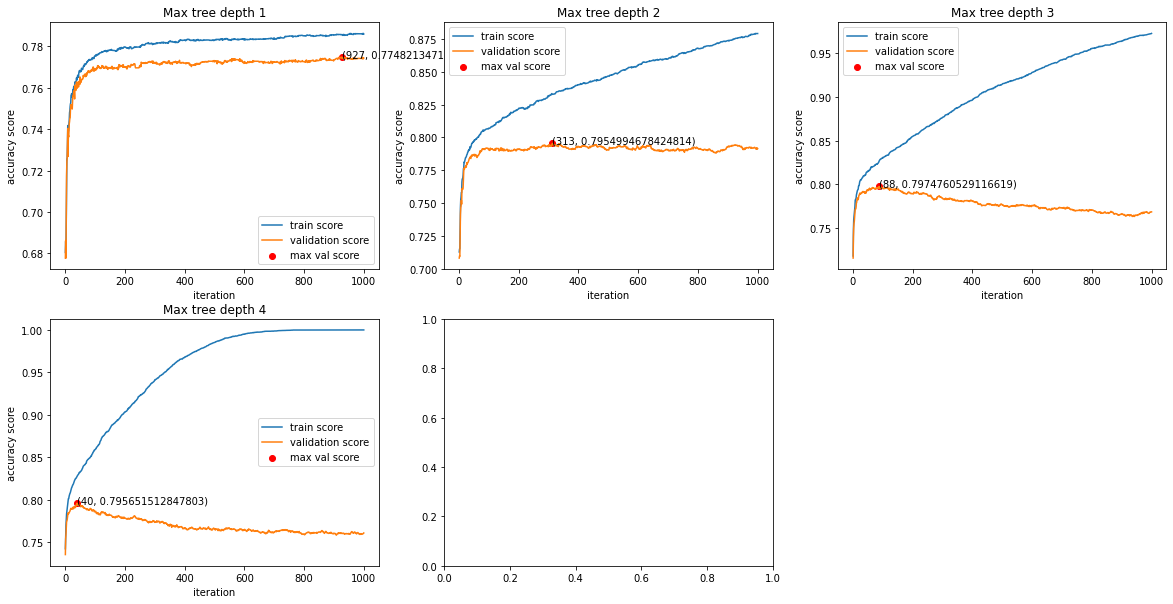

In [42]:
iters = list(range(1, 1000+1))
# fig, ax = plt.subplots(1, len(max_depths), figsize=(30, 8))
fig = plt.figure(figsize=(20, 10))
for idx,value in enumerate(max_depths):
    ax = fig.add_subplot(2, 3, value)
    ax.plot(iters,score_train_list[idx], label='train score')
    ax.plot(iters,score_val_list[idx], label='validation score')
    ax.set_ylabel('accuracy score')
    ax.set_xlabel('iteration')
    ax.set_title(f'Max tree depth {idx + 1}')
    best_depth = np.max(score_val_list[idx])
    best_iter = iters[np.argmax(score_val_list[idx])]
    ax.scatter(best_iter,best_depth, color='red', label='max val score')
    ax.annotate((best_iter,best_depth), (best_iter,best_depth))
    ax.legend()


fig.suptitle('Tree Depth and Number of Iterations effect on model accuracy')
fig.tight_layout()

In [43]:
max_score_all_depths = [max(val_list) for val_list in score_val_list]
best_treeDepth = np.argmax(max_score_all_depths)+1
best_iter = np.where(score_val_list[np.argmax(max_score_all_depths)] == np.max(max_score_all_depths))[0][0] + 1

print(f'best tree depth: {best_treeDepth}')
print(f'best interation length: {best_iter}')

best tree depth: 3
best interation length: 88


From the above plots we observe that the number of estimators and the tree depth controls the complexity of the model. In contrast to bagging, we can see that AdaBoost is prone to over-fitting as the number of trees increases. 

With a fixed learning rate of 0.5, the best validation accuracy is achieved with a max depth tree of 3 and 88 trees. Hence, in the GridSearchCV we will limit the tree depth and number of estimators between 1-4 and 0-700 respectively, along with a learning rate between 0-1. To take into consideration the effect of learning rate, we made the parameter space for number of estimators large. 

In [44]:
model = AdaBoostClassifier()

grid = dict()
grid['n_estimators'] = [100,200,300,400,500,600,700]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=depth) for depth in range(1,5)]

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv = 5, scoring='accuracy')

With the help of GridSearchCV we found that a AdaBoost model with a max depth 3, learning rate of 0.11120 and 450 estimators achieved the best validation accuracy. 

In [100]:
base_model = DecisionTreeClassifier(max_depth=3)
best_model_adaboost = AdaBoostClassifier(
    base_estimator=base_model, learning_rate=0.1111111111111111, n_estimators=500)

In [44]:
cv_results = cross_validate(best_model_AdaBoost, X_train_scaled, y_train, cv=5, scoring='accuracy', return_train_score=True)

In [45]:
train_accuracy_adaboost = cv_results['train_score'].mean()
val_accuracy_ada_boost = cv_results['test_score'].mean()
print('train accuracy: ', train_accuracy_adaboost)
print('validation accuracy', val_accuracy_ada_boost)

train accuracy:  0.8423017308307049
validation accuracy 0.8032479226989875


In [102]:
best_model_adaboost.fit(X_train_scaled, y_train)

train_accuracy_adaboost = best_model_adaboost.score(X_test_scaled, y_test)

#### 3.2.5 Neural Network

##### Setup and Definition

In [73]:
# Create a train/validation split for hyperparameter search
X_train_nn , X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train_scaled, y_train.values.reshape(-1, 1),
    test_size=0.2, shuffle=True, random_state=69)
X_val_nn, y_val_nn = torch.Tensor(X_val_nn).to(device), torch.Tensor(y_val_nn).to(device)

X_train_nn.shape, X_val_nn.shape

((26307, 16), torch.Size([6577, 16]))

In [74]:
# Define the Neural Network class
class DancingNet(nn.Module):
    def __init__(self, n_features, layer_widths, dropout=0.1):
        super().__init__()

        layers = [
            nn.Linear(n_features, layer_widths[0]),
            nn.ReLU(),
            nn.Dropout(p=dropout)
        ]

        for w1, w2 in zip(layer_widths, layer_widths[1:]):
            layers.extend([
                nn.Linear(w1, w2),
                nn.ReLU(),
                nn.Dropout(p=dropout),
            ])

        layers += [nn.Linear(layer_widths[-1], 1), nn.Sigmoid()]

        self.nn = nn.Sequential(*layers)

    def forward(self, x):
        return self.nn(x)

    def predict(self, x):
        y_pred = self(x)
        return (y_pred.detach().cpu() > 0.5).to(torch.long).numpy()

In [75]:
# Define the training loop function
def train(p, X_train, y_train, X_val, y_val):
    loader = DataLoader(
        dataset=TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)),
        batch_size=p["batch_size"],
        shuffle=True
    )

    net = DancingNet(X_train.shape[1], p["layers"], p["dropout"]).to(device)
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr=p["lr"],
        weight_decay=p["wd"],
    )

    loss_fn = nn.BCELoss()
    tra_loss, val_loss, val_acc = [], [], []
    it = tqdm(range(p["epochs"]), desc="Training NN", disable=not p["progress"])

    early_stop = p.get("early_stop", True)
    patience = 10
    strikes = 0
    best_acc = 0
    best_epoch = 0
    delta = 1e-3

    for epoch in it:
        # Train mode
        net.train()
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            y_pred = net(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

            tra_loss.append(loss.item())

        # Validation mode
        net.eval()
        with torch.no_grad():
            y_pred = net(X_val)
            val_loss.append(
                loss_fn(y_pred, y_val).detach().cpu().item()
            )
            val_acc.append(
                accuracy_score(y_pred.detach().cpu()>0.5, y_val.detach().cpu())
            )

        if early_stop:
            if val_acc[-1] > best_acc + delta:
                best_acc = val_acc[-1]
                best_epoch = epoch
                strikes = 0
            else:
                strikes += 1

            if strikes > patience:
                break
        
        it.set_postfix(dict(train=tra_loss[-1], val=val_loss[-1], acc=val_acc[-1], strikes=strikes))

    return net.eval(), tra_loss, val_loss, val_acc, best_epoch

##### Hyperparameter Search

In [50]:
# Code for hyperparameter search
def create_search_space(params):
    lists = []

    for key, values in params.items():
        lists.append(
            [(key, val) for val in values]
        )
    return list(product(*lists))

default_params = dict(
    epochs=100,
    layers=[32, 16],
    dropout=0.3,
    batch_size=2048,
    lr=1e-3,
    wd=1e-1,
    progress=False,
)

# Define the parameters to search over
search_params = dict(
    dropout=[0.01, 0.1, 0.2],
    lr=[1e-4, 1e-3, 1e-2],
    wd=[1e-1, 1e-2, 1e-3],
    layers=[[32, 16, 16], [16]*3, [8]*4],
)

search_list = create_search_space(search_params)

acc_results = []
it = tqdm(search_list, desc="Searching Params")

for candidate in it:
    params = {
        **default_params,
        **dict(candidate),
    }
    _, tra_loss, val_loss, val_acc, epoch = train(
        params, X_train_nn, y_train_nn, X_val_nn, y_val_nn,
    )
    params["epochs"] = epoch
    acc_results.append((params, max(val_acc)))

    it.set_postfix(dict(best_acc=max(acc_results, key=itemgetter(1))))

Searching Params: 100%|██████████| 81/81 [34:34<00:00, 25.62s/it, best_acc=({'epochs': 30, 'layers': [32, 16, 16], 'dropout': 0.01, 'batch_size': 2048, 'lr': 0.01, 'wd': 0.001, 'progress': False}, 0.7973240079063403)]


In [227]:
best_params = max(acc_results, key=itemgetter(1))[0]
best_params

{'epochs': 35,
 'layers': [32, 16, 16],
 'dropout': 0.1,
 'batch_size': 2048,
 'lr': 0.01,
 'wd': 0.001,
 'progress': False}

##### Train with Best Parameters

In [76]:
# Update the parameters for better visualization
best_params = {
    'epochs': 35,
    'layers': [32, 16, 16],
    'dropout': 0.1,
    'batch_size': 2048,
    'lr': 0.01,
    'wd': 0.001,
    'progress': False,
}

best_params.update({
    "progress": True,
    "early_stop": False,
})

torch.manual_seed(69)

net, tra_loss, val_loss, val_acc, _ = train(
    best_params,
    X_train_scaled, y_train.values.reshape(-1, 1),
    X_val_nn, y_val_nn,
)

Training NN: 100%|██████████| 35/35 [00:12<00:00,  2.74it/s, train=0.413, val=0.422, acc=0.812, strikes=0]


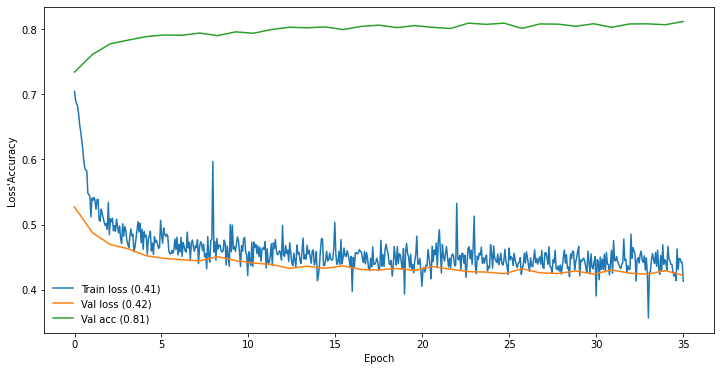

In [77]:
# Visualize the training run
fig, ax = plt.subplots(figsize=(12, 6))

epoch = best_params["epochs"]
ax.plot(np.linspace(0, epoch, len(tra_loss)), tra_loss, label=f"Train loss ({tra_loss[-1]:.2f})")
ax.plot(np.linspace(0, epoch, len(val_loss)), val_loss, label=f"Val loss ({val_loss[-1]:.2f})")
ax.plot(np.linspace(0, epoch, len(val_acc)), val_acc, label=f"Val acc ({val_acc[-1]:.2f})")

ax.legend(frameon=False)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss'Accuracy");

#### 3.2.6 Stacking 

In [55]:
# Create instances of each classifier with optimal hyperparamters
## Single tree
single_tree = DecisionTreeClassifier(max_depth=8)

## AdaBoost
base = DecisionTreeClassifier(max_depth=3)
ada_boost = AdaBoostClassifier(n_estimators=500,learning_rate=1/9)

## LogisticRegression (already defined)
logistic_pipe

## RandomForest
random_forest = RandomForestClassifier(n_estimators=500,max_depth=19,verbose=True,n_jobs=-1)

In [80]:
ensemble_stacking = StackingClassifier([("Tree", DecisionTreeClassifier(max_depth=8)),
                               ("AdaBoost", ada_boost),
                               ("Logistic Regression", logistic_pipe),
                               ("Random Forest", random_forest)],
                                       n_jobs=-1, verbose=True)

ensemble_stacking.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('Tree', DecisionTreeClassifier(max_depth=8)),
                               ('AdaBoost',
                                AdaBoostClassifier(learning_rate=0.1111111111111111,
                                                   n_estimators=500)),
                               ('Logistic Regression',
                                Pipeline(steps=[('PolyFeat',
                                                 PolynomialFeatures()),
                                                ('LogisticRegression',
                                                 LogisticRegression(C=21.54,
                                                                    max_iter=1000,
                                                                    n_jobs=-1,
                                                                    verbose=1))])),
                               ('Random Forest',
                                RandomForestClassifier(max_depth=19,
                      

In [81]:
train_accuracy_stacking = ensemble_stacking.score(X_train_scaled, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.8s finished


In [82]:
print('train score for stacking:', train_accuracy_stacking)

train score for stacking: 0.961653083566476


## 4. Results

Below we report test accuracy and confusion matrix for each trained model

In [150]:
# Function to calculate False-Positive Rate
def fpr(cm):
    # extract the number of false positives
    fp = cm[0][1]

    # calculate the total number of negatives
    tn = cm[0][0] + cm[0][1]

    # calculate the false positive rate
    return fp / tn

In [158]:
def show_conf_mat(conf_matm, name):
    _, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(x=j, y=i,s=conf_mat[i, j], va='center', ha='center', size='xx-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title(f'Confusion Matrix for {name}', fontsize=18)
    plt.show()

In [83]:
# Load in the test data
test_data = pd.read_csv("/data/notebook_files/test.csv").rename(columns={"Unnamed: 0": "orig_idx"})
X_test = test_data.drop(['target'], axis=1)
y_test = test_data['target']
X_test = X_test[predictors]

# Scale test data
X_test_scaled = scaler.transform(X_test)

#### 4.1 Single Decision Tree

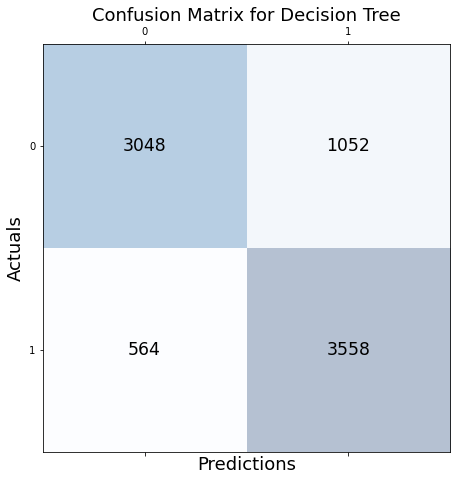

In [164]:
single_dt = DecisionTreeClassifier(max_depth=8).fit(X_train_scaled,y_train)
test_accuracy_single_dt = single_dt.score(X_test_scaled,y_test)

y_pred_dt = single_dt.predict(X_test_scaled)
confmat_dt = confusion_matrix(y_test, y_pred_dt)
test_fpr_single_dt = fpr(confmat_dt)

show_conf_mat(confmat_dt, "Decision Tree")

#### 4.2 Logistic Regression

In [159]:
test_accuracy_logistic = logistic_pipe.score(X_test_scaled, y_test)

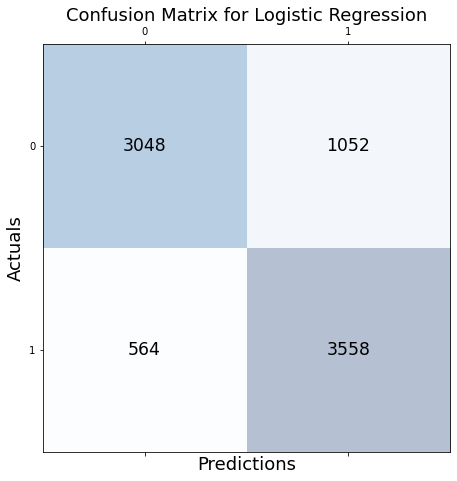

In [160]:
logistic_predictions = logistic_pipe.predict(X_test_scaled)
confmat_lr = confusion_matrix(y_test, logistic_predictions)

test_fpr_logistic = fpr(confmat_lr)

show_conf_mat(confmat_lr, "Logistic Regression")

#### 4.3 Random Forest

In [132]:
best_rf = RandomForestClassifier(max_depth=19, n_estimators=500, max_features="sqrt")
best_rf.fit(X_train_scaled,y_train)
test_accuracy_rf = best_rf.score(X_test_scaled,y_test)

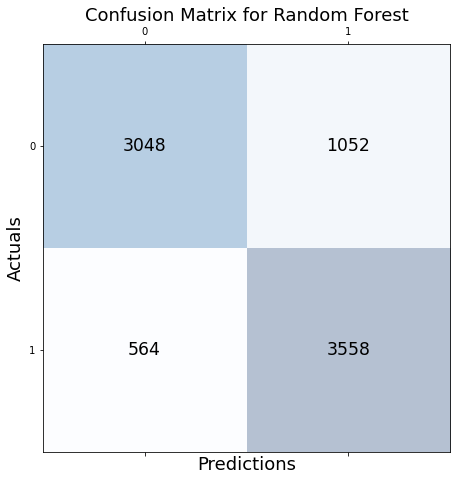

In [167]:
y_pred_rf = best_rf.predict(X_test_scaled)
confmat_rf = confusion_matrix(y_test, y_pred_rf)
test_fpr_rf = fpr(confmat_rf)
show_conf_mat(confmat_rf, "Random Forest")

#### 4.4 AdaBoost

In [92]:
# AdaBoost
best_model_AdaBoost.fit(X_train_scaled,y_train)
test_accuracy_adaboost = best_model_AdaBoost.score(X_test_scaled,y_test)

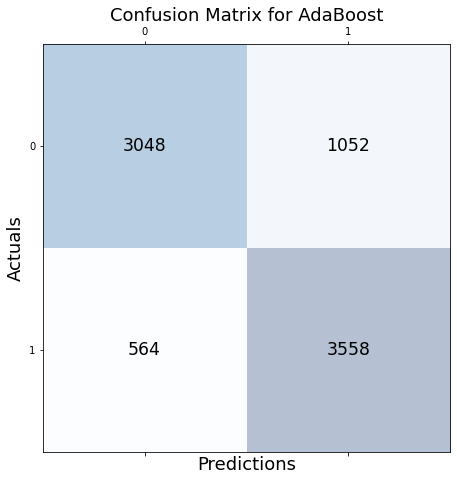

In [169]:
y_pred_adaBoost = best_model_AdaBoost.predict(X_test_scaled)
confmat_ada = confusion_matrix(y_test, y_pred_adaBoost)
test_fpr_adaboost = fpr(confmat_ada)
show_conf_mat(confmat_ada, "AdaBoost")

#### 4.5 Neural Networks

In [94]:
train_accuracy_nn = accuracy_score(y_train,
    net.predict(torch.Tensor(X_train_scaled).to(device)))

y_pred = net.predict(torch.Tensor(X_test_scaled).to(device))
test_accuracy_nn = accuracy_score(y_test, y_pred)

print(f"Train score: {train_accuracy_nn:.7f}, Test score: {test_accuracy_nn:.7f}")

Train score: 0.8072923, Test score: 0.7984675


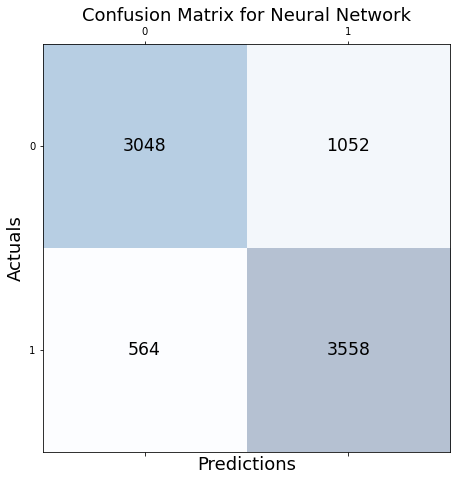

In [171]:
confmat_nn = confusion_matrix(y_test, y_pred)
test_fpr_nn = fpr(confmat_nn)
show_conf_mat(confmat_nn, "Neural Network")

#### 4.6 Stacking

In [96]:
test_accuracy_stacking = ensemble_stacking.score(X_test_scaled,y_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.6s finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.0s finished


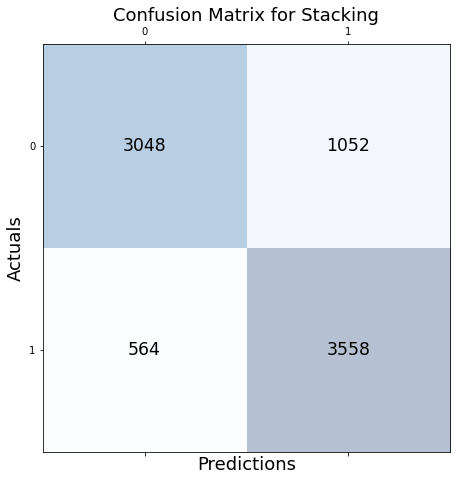

In [174]:
stacking_predictions = ensemble_stacking.predict(X_test_scaled)
confmat_stacking = confusion_matrix(y_test, stacking_predictions)
test_fpr_stacking = fpr(confmat_stacking)
show_conf_mat(confmat_stacking, "Stacking")

#### 4.7 Summary of Results

In [176]:
names = [
    "Single Descision Tree",
    "Logistic regression",
    "Random Forest",
    "AdaBoost",
    "Neural Network",
    "Stacking",
]

train_score = [
    train_accuracy_tree,
    train_accuracy_logistic,
    train_accuracy_rf,
    train_accuracy_adaboost,
    train_accuracy_nn,
    train_accuracy_stacking,
]

test_score = [
    test_accuracy_single_dt,
    test_accuracy_logistic,
    test_accuracy_rf,
    test_accuracy_adaboost,
    test_accuracy_nn,
    test_accuracy_stacking,
]

fpr_score = [
    test_fpr_single_dt,
    test_fpr_logistic,
    test_fpr_rf,
    test_fpr_adaboost,
    test_fpr_nn,
    test_fpr_stacking,
]

final_scores_df = pd.DataFrame(
    list(zip(names, train_score, test_score, fpr_score)),
    columns=["Model","Train Accuracy","Test Accuracy", "FPR"],
).round(decimals=4)

final_scores_df.set_index("Model")

Train Accuracy 
 Test Accuracy 
 FPR 
 
 
 Model 
 
 
 
 
 
 
 
 Single Descision Tree 
 0.7902 
 0.7637 
 0.3263 
 
 
 Logistic regression 
 0.7915 
 0.7889 
 0.2749 
 
 
 Random Forest 
 0.9696 
 0.8055 
 0.2566 
 
 
 AdaBoost 
 0.8036 
 0.8035 
 0.2566 
 
 
 Neural Network 
 0.8073 
 0.7985 
 0.2527 
 
 
 Stacking 
 0.9617 
 0.8069 
 0.2320

## 5. Wrap Up

This concludes the work performed for the Spotify hit prediction task. If there's any questions or bugs, please reach out to larsankile@g.harvard.edu.